In [2]:
!splitcode --version
!kb --version
!fastq-dump --version

splitcode, version 0.30.0


usage: kb [-h] [--list] <CMD> ...

kb_python 0.29.3

positional arguments:
  <CMD>
    info      Display package and citation information
    compile   Compile `kallisto` and `bustools` binaries from source
    ref       Build a kallisto index and transcript-to-gene mapping
    count     Generate count matrices from a set of single-cell FASTQ files
    extract   Extract sequencing reads that were pseudoaligned to specific
              genes/transcripts (or extract all reads that were / were not
              pseudoaligned)

options:
  -h, --help  Show this help message and exit
  --list      Display list of supported single-cell technologies

fastq-dump : 3.0.3 ( 3.0.2 )



In [2]:
outdir = "/mnt/data1/10XvParse/Analysis_3/"
fasta_folder = "FASTA/Raw/"
sra_folder = "SRA/"
tmp_folder = "tmp/"
file_names = []
srrs = []

with open("parse_extraction/10x_accession.txt") as access:
    for line in access:
        line = line.strip()
        if line.startswith('H'):
            name = f"10x_{line}"
        else:
            file_names.append(name)
            srrs.append(line)

In [5]:
for srr, name in zip(srrs, file_names):
    print(outdir+fasta_folder+name)
    !prefetch {srr} --max-size u -O {outdir+sra_folder}
    !fasterq-dump --outdir {outdir+fasta_folder} --temp {outdir+tmp_folder} \
        --outfile {name+".fastq"} --split-files --skip-technical \
        {outdir+sra_folder+srr+"/"+srr+".sra"} --threads 8
    !pigz {outdir+fasta_folder+name+"_1.fastq"} -p 8
    !pigz {outdir+fasta_folder+name+"_2.fastq"} -p 8

/mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H1_1

2025-08-07T03:14:42 prefetch.3.0.3: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2025-08-07T03:14:43 prefetch.3.0.3: 1) Downloading 'SRR26594154'...
2025-08-07T03:14:43 prefetch.3.0.3: SRA Normalized Format file is being retrieved, if this is different from your preference, it may be due to current file availability.
2025-08-07T03:14:43 prefetch.3.0.3:  Downloading via HTTPS...
2025-08-07T03:44:43 prefetch.3.0.3:  HTTPS download succeed
2025-08-07T03:44:43 prefetch.3.0.3:   verifying 'SRR26594154'...
2025-08-07T03:45:32 prefetch.3.0.3:  'SRR26594154' is valid
2025-08-07T03:45:32 prefetch.3.0.3: 1) 'SRR26594154' was downloaded successfully
2025-08-07T03:45:32 prefetch.3.0.3: 'SRR26594154' has 0 unresolved dependencies
spots read      : 203,134,663
reads read      : 406,269,326
reads written   : 406,269,326
/mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H2_2

2025-08-07T04:29:11 prefetc

In [4]:
batch_file = "batch/10x_batch.txt"
with open(batch_file, "w") as batch:
    for file in file_names:
        fastq_files = [outdir + fasta_folder + file + "_1.fastq.gz", 
                   outdir + fasta_folder + file + "_2.fastq.gz"]
        batch.write(f"{file}\t{fastq_files[0]}\t{fastq_files[1]}\n")

In [5]:
proc_folder = "FASTA/Processed/"
proc_files = [outdir + proc_folder + "10x_1.fastq.gz", 
                outdir + proc_folder + "10x_2.fastq.gz"]
mapping = "run_info/10x_mapping.txt"
outb = "run_info/10x_barcodes.fastq.gz"

In [6]:
!splitcode --remultiplex \
    --nFastqs=2 --gzip -o {proc_files[0]},{proc_files[1]} \
    --outb={outb} --mapping={mapping} {batch_file} -t 8

* Using a list of 0 tags (vector size: 0; map size: 0; num elements in map: 0)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H1_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H1_2.fastq.gz
* will process sample 2: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H2_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H2_2.fastq.gz
455M reads processed         
done 
* processed 457,238,051 reads


In [7]:
path = "/mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H1"
read_out = outdir + "test_out/"

!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x 10XV3 -o {read_out} {path + "_1.fastq.gz"} {path + "_2.fastq.gz"}


[2025-08-11 16:14:35,839]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/test_out/ from
[2025-08-11 16:14:35,840]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H1_1.fastq.gz
[2025-08-11 16:14:35,840]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H1_2.fastq.gz
[2025-08-11 16:31:52,174]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/test_out/output.bus to /mnt/data1/10XvParse/Analysis_3/test_out/tmp/output.s.bus
[2025-08-11 16:32:19,413]    INFO [count] On-list not provided
[2025-08-11 16:32:19,413]    INFO [count] Copying pre-packaged 10XV3 on-list to /mnt/data1/10XvParse/Analysis_3/test_out/
[2025-08-11 16:32:19,929]    INFO [count] Inspecting BUS file /mnt/data1/10XvParse/Analysis_3/test_out/tmp/output.s.bus
[2025-08-11 16:32:34,750]    INFO [count] Correcting BUS records in /mnt/data1/10XvParse/Analysis_3/test_out/tmp/output.s.bus to /mnt/data1/10XvParse/Analysis_3/test_ou

In [16]:
# Download human genome
!kb ref --overwrite -d human -i index.idx -g t2g.txt

[2025-08-07 14:11:04,583]    INFO [download] Downloading files for human (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/human_index_standard.tar.xz to tmp/human_index_standard.tar.xz
100%|████████████████████████████████████████| 138M/138M [00:03<00:00, 40.7MB/s]
[2025-08-07 14:11:08,147]    INFO [download] Extracting files from tmp/human_index_standard.tar.xz


In [17]:
# Perform pseudoalignment of 10x reads
read_out = outdir + "10x_out/"
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x 10XV3 -o {read_out} {proc_files[0]} {proc_files[1]}

[2025-08-07 14:11:35,717]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/10x_out/ from
[2025-08-07 14:11:35,717]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/10x_1.fastq.gz
[2025-08-07 14:11:35,717]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/10x_2.fastq.gz
[2025-08-07 14:52:20,377]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/10x_out/output.bus to /mnt/data1/10XvParse/Analysis_3/10x_out/tmp/output.s.bus
[2025-08-07 14:53:23,783]    INFO [count] On-list not provided
[2025-08-07 14:53:23,783]    INFO [count] Copying pre-packaged 10XV3 on-list to /mnt/data1/10XvParse/Analysis_3/10x_out/
[2025-08-07 14:53:25,022]    INFO [count] Inspecting BUS file /mnt/data1/10XvParse/Analysis_3/10x_out/tmp/output.s.bus
[2025-08-07 14:53:48,055]    INFO [count] Correcting BUS records in /mnt/data1/10XvParse/Analysis_3/10x_out/tmp/output.s.bus to /mnt/data1/10XvParse/Analysis_3/10x_out

In [18]:
# Import packages
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from pybiomart import Server

# Preprocess

In [19]:
data = anndata.read_h5ad(outdir+'10x_out/counts_unfiltered/adata.h5ad')

#read in gene names and replace as index
data.var['gene_codes'] = data.var.index.tolist()

gene_names = []

with open(outdir+'10x_out/counts_unfiltered/cells_x_genes.genes.names.txt', 'r') as file:
    for line in file:
        gene_names.append(line.strip())

data.var_names = gene_names

# set up metadata for genes and cells
data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
data.obs['n_counts'] = data.X.sum(axis=1).A1
sc.pp.filter_genes(data, min_cells=1)
sc.pp.filter_cells(data, min_genes=1)

# 10x Quality Control

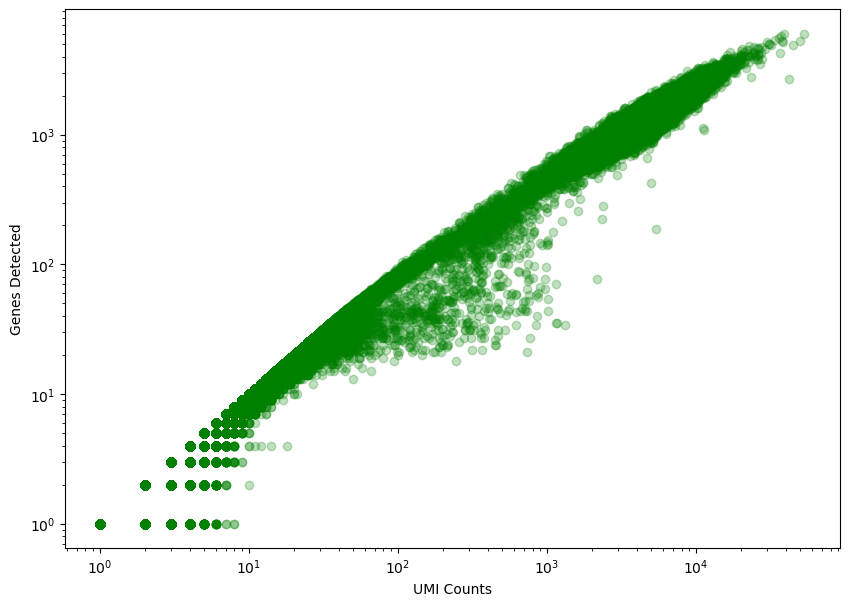

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')

plt.show()

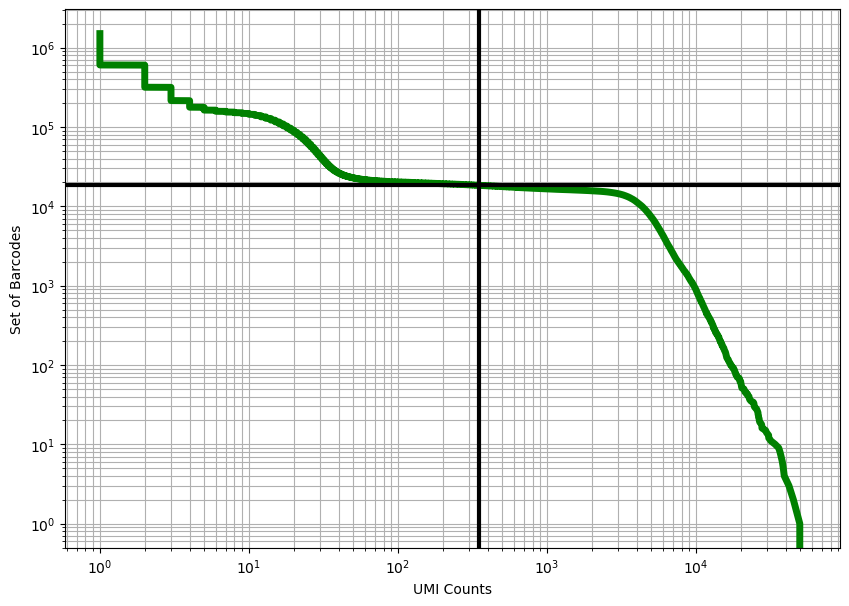

In [21]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 350  #@param {type:"integer"}
knee = np.sort((np.array(data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [22]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

18,383 cells passed the 350 UMI threshold


In [23]:
# Query Ensembl for lncRNA genes
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['hsapiens_gene_ensembl']

result = dataset.query(attributes=[
    'ensembl_gene_id_version', 'transcript_biotype'
], filters={'transcript_biotype': ['lncRNA']})

In [29]:
# Identify lncRNA genes
data.var["is_lnc"] = data.var["gene_codes"].isin(result["Gene stable ID version"])

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
data.var["is_mito"] = data.var.index.str.startswith("MT")
# ribosomal genes
data.var["is_ribo"] = data.var.index.str.startswith(("RPS", "RPL"))

mito_counts = data[:, data.var['is_mito']].X.sum(axis=1)
ribo_counts = data[:, data.var['is_ribo']].X.sum(axis=1)
nc_counts = data[:, data.var['is_lnc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
data.obs['percent_lnc'] = np.array(nc_counts / total_counts * 100).flatten()

data.obs['n_counts'] = data.X.sum(axis=1).A1

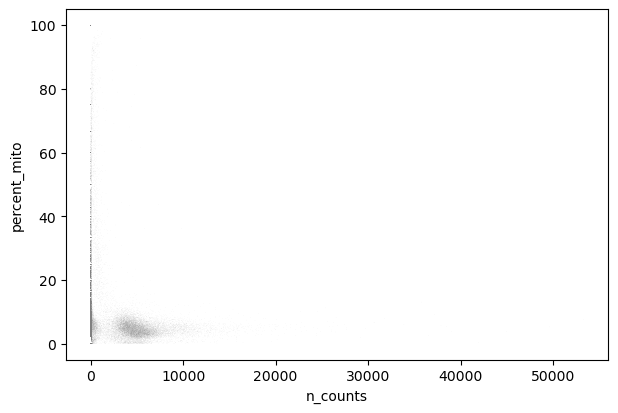

In [30]:
sc.pl.scatter(data, x='n_counts', y='percent_mito')

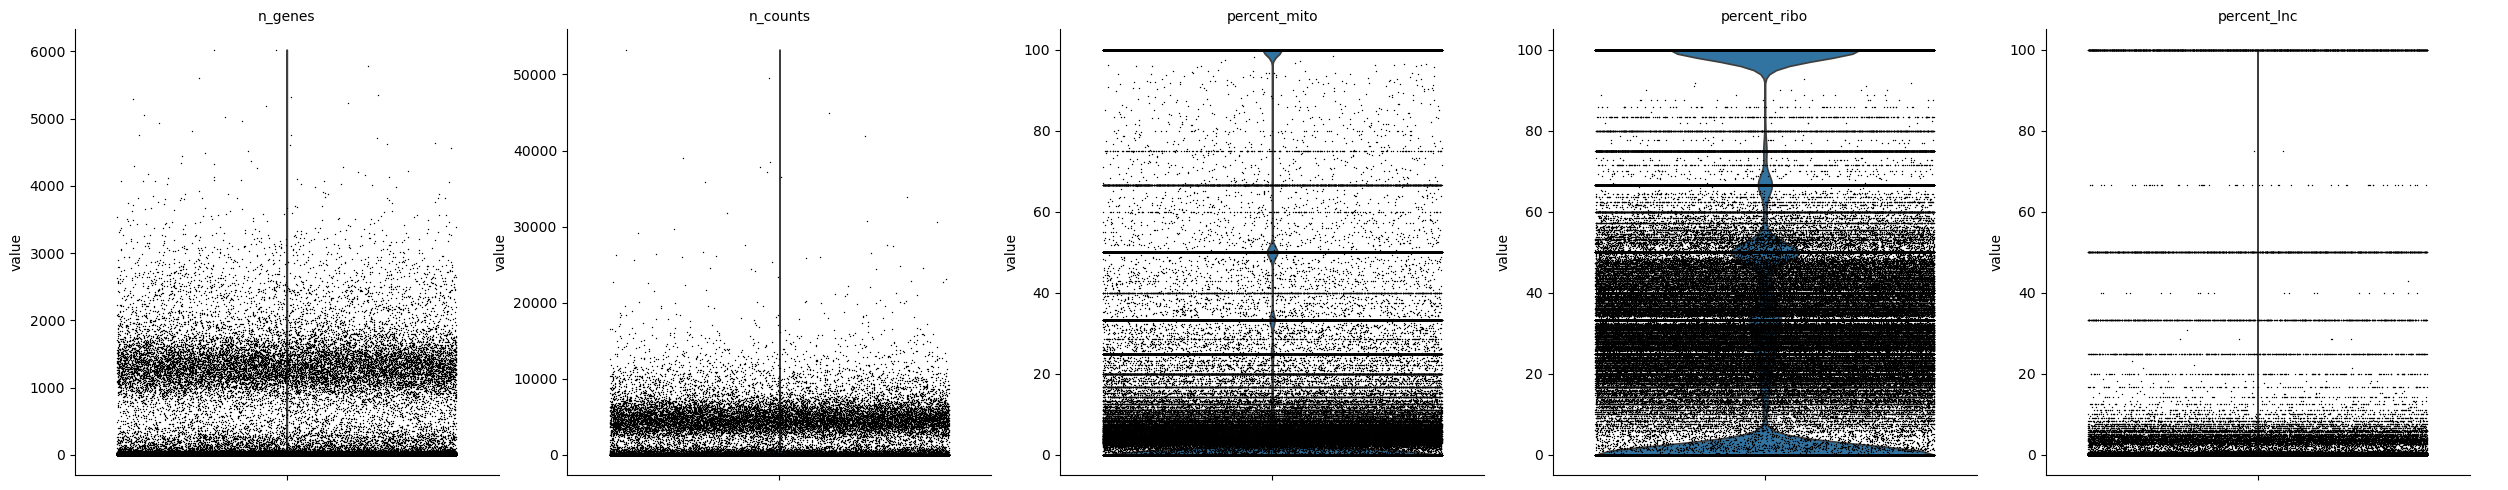

In [31]:
sc.pl.violin(data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)


# 10x Gene Counts

In [32]:
# Find top 10 genes by number of cells expressed
genes = data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

In [33]:
# Get percent counts for each gene and add to metadata
data.var['percent_counts'] = data.X.sum(axis=0).A1  / data.X.sum() * 100

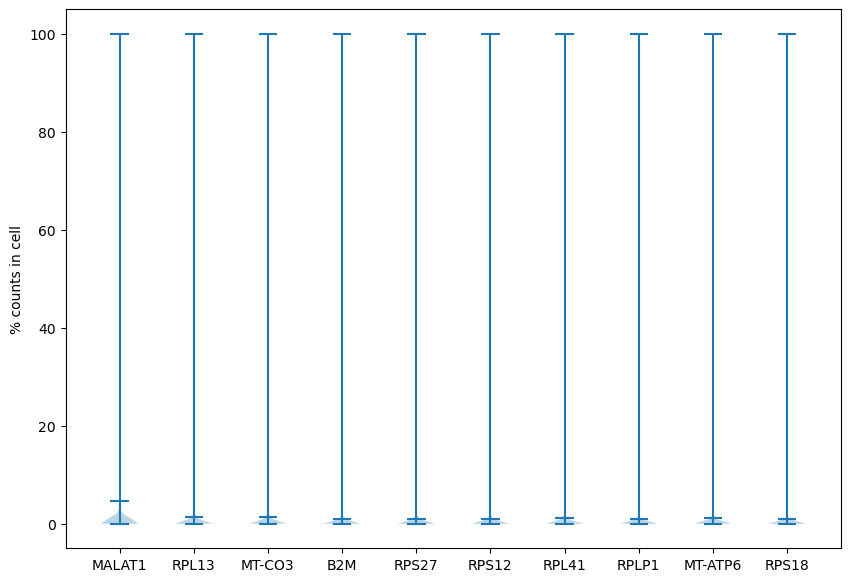

In [34]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()